# Decision Tree Classifier from sklearn

see: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html

and: https://scikit-learn.org/dev/auto_examples/ensemble/plot_adaboost_twoclass.html

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
from ROOT import *
from array import array

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For random number generation

from scipy.stats import norm
from scipy.stats import expon

# For plot
import graphviz
from matplotlib import pyplot as plt
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 

### (2) Define generation procedure for "signal" and "background" distributions

In [3]:
# Normal distribution in (R,Phi) with correlation for signal

def mysig(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,2))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    r  = pos[0] + sig[0]*(g[0]*cos(phi) + g[1]*sin(phi))
    th = pos[1] + sig[1]*(g[0]*sin(phi) + g[1]*cos(phi))

    data[:,0] = r * np.cos(th)
    data[:,1] = r * np.sin(th)
    
    return data

# Exponential distribution with correlation for background

def mybg(Nmc,pos,sig,corr=0.0):

    data = np.ones(shape=(Nmc,2))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    r1_tab = g[0]*cos(phi) + g[1]*sin(phi)
    r2_tab = g[0]*sin(phi) + g[1]*cos(phi)

# Convert correlated gaussian variables r1 & r2 
# to correlated exponential variables, based on survival function

    s1_tab = norm.sf(r1_tab)
    s2_tab = norm.sf(r2_tab)
    
    data[:,0] = pos[0] + sig[0]*expon.isf(s1_tab)
    data[:,1] = pos[1] + sig[1]*expon.isf(s2_tab)
    
    return data

### (3) Generating training and test data

In [4]:
# Sample size

Ntrain = 1000
Ntest = 1000

# Two hypothesis:

# H1: Background - exponential

h1 = np.array([-2.0,-2.0])
sig1 = np.array([2.0,2.0])
corr1 = 0.0

# H2: Signal - normal in (R,phi)

h2 = np.array([1.,0.78])
sig2 = np.array([0.25,1.0])
corr2 = 0.97

# Fraction of signal (h2) hypothesis

fh2 = 0.5

fh1 = 1 - fh2

# Generate train sample 
# ---------------------

h1train = mybg(Ntrain,h1,sig1,corr1)
h2train = mysig(Ntrain,h2,sig2,corr2)

# Uniform distributed numbers

rtrain = np.random.uniform(size=Ntrain)

# Mix of two hypothesis

y_train = rtrain < fh2

y2_train = np.resize(np.repeat(y_train,2),(Ntrain,2))

X_train = y2_train * h2train + (1 - y2_train)*h1train

print("Train data defined, size: ",y_train.size)

# Generate test sample 
# --------------------

h1test = mybg(Ntest,h1,sig1,corr1)
h2test = mysig(Ntest,h2,sig2,corr2)

# Uniform distributed numbers

rtest = np.random.uniform(size=Ntest)

# Mix of two hypothesis

y_test = rtest < fh2

y2_test = np.resize(np.repeat(y_test,2),(Ntest,2))

X_test = y2_test * h2test + (1 - y2_test)*h1test

print("Test data defined, size: ",y_test.size)

# Rescale category from {0,1} to {-1,1}

y_train = 2*y_train - 1
y_test = 2*y_test - 1

Train data defined, size:  1000
Test data defined, size:  1000


### (4) BDT classifier

In [5]:
dmax = 4
lmin = 1
nest = 20

clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=dmax,min_samples_leaf=lmin), algorithm="SAMME", n_estimators=nest
)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)

print("Number of mislabeled training points out of a total %d points : %d"
        % (X_train.shape[0], (y_train != y_train_pred).sum()))

y_test_pred  = clf.predict(X_test)

print("Number of mislabeled test points out of a total %d points : %d"
        % (X_test.shape[0], (y_test != y_test_pred).sum()))

Number of mislabeled training points out of a total 1000 points : 0
Number of mislabeled test points out of a total 1000 points : 54


### (5) Plot results

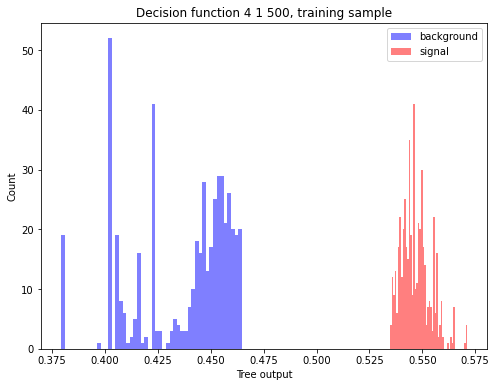

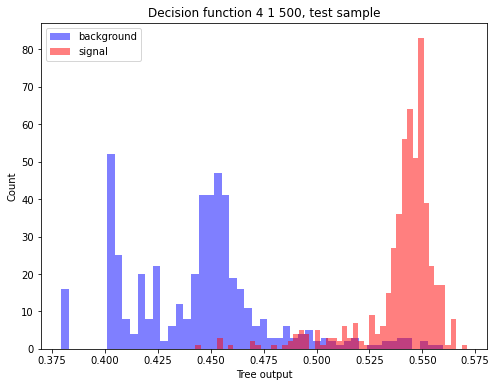

In [6]:
# Distribution of the NN output value


fig = plt.figure(figsize=(8, 6))

dec = clf.predict_proba(X_train)[:, 1]

plt.hist(dec[y_train == -1.0], bins=50, color="b", alpha=0.5, label='background')
plt.hist(dec[y_train == 1.0], bins=50,  color="r", alpha=0.5, label='signal')

plt.xlabel('Tree output')
plt.ylabel('Count')
plt.title("Decision function "+str(dmax)+" "+str(lmin)+" "+str(nest)+", training sample")
plt.legend();

fname = '12_skBDT_'+str(dmax)+'_'+str(lmin)+'_'+str(nest)+'_train_dec'

plt.savefig(fname)

plt.show()

fig2 = plt.figure(figsize=(8, 6))

dec2 = clf.predict_proba(X_test)[:, 1]

plt.hist(dec2[y_test == -1.0], bins=50, color="b", alpha=0.5, label='background')
plt.hist(dec2[y_test == 1.0], bins=50,  color="r", alpha=0.5, label='signal')

plt.xlabel('Tree output')
plt.ylabel('Count')
plt.title("Decision function "+str(dmax)+" "+str(lmin)+" "+str(nest)+", test sample")
plt.legend();

fname = '12_skBDT_'+str(dmax)+'_'+str(lmin)+'_'+str(nest)+'_test_dec'

plt.savefig(fname)

plt.show()



In [7]:
# Square plot

gStyle.SetCanvasDefW(900)
gStyle.SetCanvasDefH(600)
 
# Create plot canvas

cexp = TCanvas('cexp')
   
# Create data graph - train data

tgr = TGraph(y_train.size,array('d',X_train[:,0]),array('d',X_train[:,1]))

# Set graph options

tgr.SetNameTitle("tgr","Linear discriminant - percepton learning")
tgr.SetMarkerStyle(20)
tgr.SetMarkerSize(0.7)
tgr.SetMarkerColor(2)

tgr.GetXaxis().SetTitle("x_{1}")
tgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

nt1 = np.sum(y_train==1)

Xt1 = np.zeros(shape=(nt1,2))

it1 = 0
for ip in range(y_train.size):
    if y_train[ip]==1 :
        Xt1[it1]=X_train[ip]
        it1+=1
             
tgr1 = TGraph(int(nt1),array('d',Xt1[:,0]),array('d',Xt1[:,1]))

# Set graph options

tgr1.SetNameTitle("tgr1","Train data")
tgr1.SetMarkerStyle(20)
tgr1.SetMarkerSize(0.7)
tgr1.SetMarkerColor(3)
    
# Create data graph - test data

rgr = TGraph(y_test.size,array('d',X_test[:,0]),array('d',X_test[:,1]))

# Set graph options

rgr.SetNameTitle("rgr","Linear discriminant - single percepton learning")
rgr.SetMarkerStyle(20)
rgr.SetMarkerSize(0.7)
rgr.SetMarkerColor(2)

rgr.GetXaxis().SetTitle("x_{1}")
rgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

n1 = np.sum(y_test==1)

X1 = np.zeros(shape=(n1,2))

ip1 = 0
for ip in range(y_test.size):
    if y_test[ip]==1 :
        X1[ip1]=X_test[ip]
        ip1+=1
        


        
rgr1 = TGraph(int(n1),array('d',X1[:,0]),array('d',X1[:,1]))

# Set graph options

rgr1.SetNameTitle("rgr1","Test data")
rgr1.SetMarkerStyle(20)
rgr1.SetMarkerSize(0.7)
rgr1.SetMarkerColor(3)
    

In [8]:
# Decision histogram (as background)
Xmin = -1.999
Xmax =  3.999

Nbin = 240
dX = (Xmax-Xmin)/Nbin

htit = "Boosted Decision tree classifier, max depth: "+str(dmax)+", min leaf: "+str(lmin)+", trees: "+str(nest)

nbhist = TH2D("nbhist",htit,Nbin,Xmin,Xmax,Nbin,Xmin,Xmax)

for ix in range(Nbin):
    for iy in range(Nbin):
        x1 = Xmin+(ix+0.5)*dX
        x2 = Xmin+(iy+0.5)*dX
        X = np.array([[x1,x2]])
        
        ypred = clf.predict(X)
        
        nbhist.Fill(x1,x2,0.5*ypred[0]+0.5)

# Do not show histogram statistics

nbhist.SetStats(0)

nbhist.GetXaxis().SetTitle("x_{1}")
nbhist.GetYaxis().SetTitle("x_{2}")


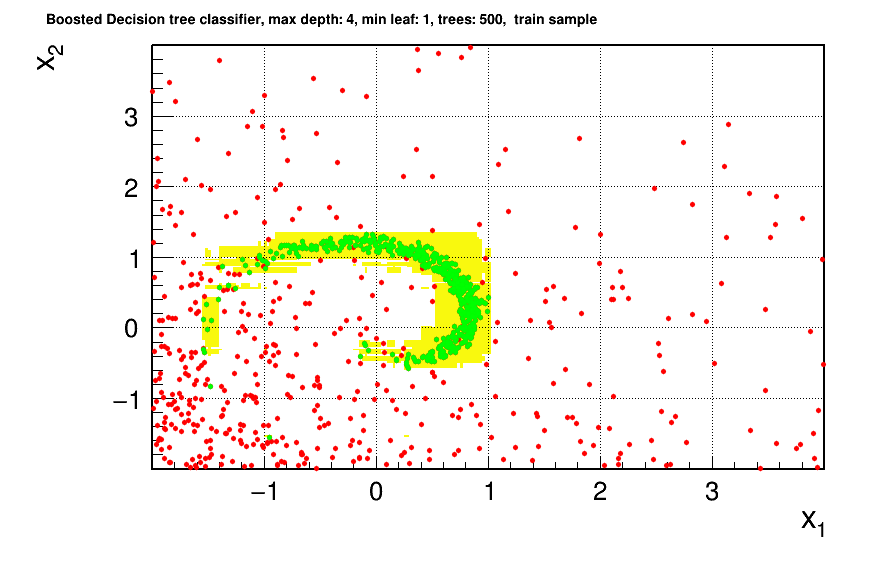

Info in <TCanvas::Print>: png file 12_skBDT_4_1_500_train.png has been created


In [9]:
# Plot 

nbhist.SetTitle(htit+",  train sample")

nbhist.Draw("COL")

tgr.Draw('P')
tgr1.Draw('P')

cexp.Update()

fname = '12_skBDT_'+str(dmax)+'_'+str(lmin)+'_'+str(nest)+'_train.png'
    
cexp.Print(fname)

Image(filename=fname)

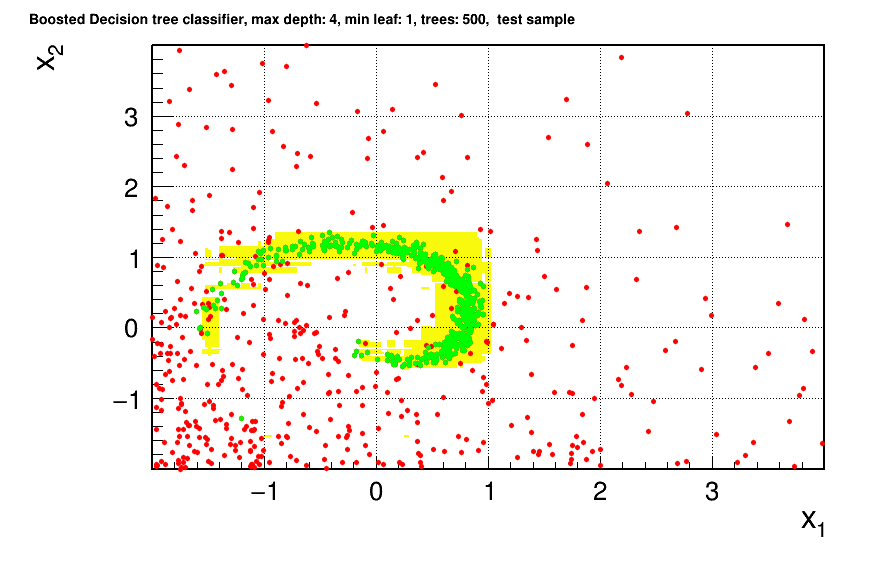

Info in <TCanvas::Print>: png file 12_skBDT_4_1_500_test.png has been created


In [10]:
# Plot 

nbhist.SetTitle(htit+",  test sample")

nbhist.Draw("COL")

rgr.Draw('P')
rgr1.Draw('P')

cexp.Update()

fname = '12_skBDT_'+str(dmax)+'_'+str(lmin)+'_'+str(nest)+'_test.png'
    
cexp.Print(fname)

Image(filename=fname)